In [49]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
import gzip
import ast
from textblob import TextBlob

Cargo los datos

In [2]:


# Abre el archivo comprimido y carga los datos JSON
with gzip.open("steam_games.json.gz", 'rt', encoding='utf-8') as archivo_comprimido:
    # Carga los datos JSON en un DataFrame
    games = pd.read_json(archivo_comprimido, lines=True)
reviews = pd.read_parquet('user_reviews.parquet')
item = pd.read_parquet('australian_users_items.parquet')

## EDA  steam_games:

Vemos un primer viztazo a los datos, las primeras y ultimas filas:

In [7]:
games.head()


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


In [9]:
#Ultimas 5 filas:
games.tail()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns"
120444,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,1.0,681550.0,None


Notamos que no todas las filas son nulas revisamos cuantas son

In [19]:
#Cantidad de filas nulas
filas_con_nulos = games[games.isnull().all(axis=1)]
print(f" La cantidad de filas nulas son: {len(filas_con_nulos)}")

 La cantidad de filas nulas son: 88310


Con respecto a las filas que no son nulas notamos que las columnas 'tags' y 'genres' tienen valores parecidos, ademas ambas columnas estan anidadas, por lo que se debería desanidar:

In [11]:
games[["tags","genres"]].tail()

,tags,genres
120440,"[Strategy, Indie, Casual, Simulation]","[Casual, Indie, Simulation, Strategy]"
120441,"[Strategy, Indie, Casual]","[Casual, Indie, Strategy]"
120442,"[Indie, Simulation, Racing]","[Indie, Racing, Simulation]"
120443,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Casual, Indie]"
120444,"[Early Access, Adventure, Indie, Action, Simul...",None


De la columna "release_date" viene la fecha completa y para el proyecto solo necesito el año. El cual se debera sacar solo el año:

In [12]:
games.release_date.tail() 

120440    2018-01-04
120441    2018-01-04
120442    2018-01-04
120443    2017-09-02
120444          None
Name: release_date, dtype: object

También notamos que de la columna 'price' hay precios que deberian ser 0 y estan en palabras como Free to play, Free, Free to use, entre otros mas por ende este un str y deberiamos convertirlos en float una vez corregidos:

In [13]:
games.price.value_counts().tail()

price
74.76          1
32.99          1
14.95          1
26.99          1
Free to Use    1
Name: count, dtype: int64

Arreglamos la columna 'price' para poder guardar el dataset:

Primero revisamo si free to use es el unico valor no numerico

In [14]:
# Convertir la columna 'price' a numérico, los valores no convertibles serán NaN
games['price_numeric'] = pd.to_numeric(games['price'], errors='coerce')

# Filtrar los valores que no son numéricos
valores_no_numericos = games[games['price_numeric'].isna()]['price']

# Obtener el recuento de valores únicos no numéricos
conteo_valores_no_numericos = valores_no_numericos.value_counts()

# Mostrar el recuento de valores únicos no numéricos
print("Recuento de valores únicos no numéricos de la columna 'price':")
print(conteo_valores_no_numericos)

# Obtener el número de valores únicos no numéricos
num_valores_no_numericos_unicos = valores_no_numericos.nunique()

# Imprimir el número de valores únicos no numéricos
print(f"Número de valores únicos no numéricos en la columna 'price': {num_valores_no_numericos_unicos}")

games = games.drop(columns=['price_numeric'])

Recuento de valores únicos no numéricos de la columna 'price':
price
Free                             905
Free to Play                     520
Free To Play                     462
Free Mod                           4
Free Demo                          3
Play Now                           2
Third-party                        2
Play for Free!                     2
Play WARMACHINE: Tactics Demo      1
Install Theme                      1
Install Now                        1
Free HITMAN™ Holiday Pack          1
Play the Demo                      1
Starting at $499.00                1
Starting at $449.00                1
Free to Try                        1
Free Movie                         1
Free to Use                        1
Name: count, dtype: int64
Número de valores únicos no numéricos en la columna 'price': 18


Vemos que hay 18 valores no numericos procedemos a remplazarlor por 0.00 debido a que la mayoria es para decir gratis

In [3]:
# Definir un diccionario de mapeo de valores a reemplazar y su valor de reemplazo
mapeo_reemplazo = {'Free': '0', 'Free To Play': '0', 'Free Mod' : '0' ,'Free Demo' : '0' ,'Play for Free!' :'0' ,'Third-party' : '0' ,'Play Now' : '0' ,'Install Now' : '0' ,'Play WARMACHINE: Tactics Demo' : '0' ,'Install Theme' : '0' ,'Free HITMAN™ Holiday Pack' : '0' ,'Play the Demo' : '0' ,'Free to Try' : '0' ,'Free to Use' : '0','Free to Play' : '0','Starting at $449.00' : '0','Starting at $499.00 ' : '0','Free Movie' : '0'}

# Reemplazar los valores en la columna 'price' según el diccionario de mapeo
games['price'] = games['price'].replace(mapeo_reemplazo)
games['price'] = pd.to_numeric(games['price'], errors='coerce')
#esta ultima linia combierte los '0' = 0.00 

Comprobamos


In [4]:
# Convertir la columna 'price' a numérico, los valores no convertibles serán NaN
games['price_numeric'] = pd.to_numeric(games['price'], errors='coerce')

# Filtrar los valores que no son numéricos
valores_no_numericos = games[games['price_numeric'].isna()]['price']

# Obtener el recuento de valores únicos no numéricos
conteo_valores_no_numericos = valores_no_numericos.value_counts()

# Mostrar el recuento de valores únicos no numéricos
print("Recuento de valores únicos no numéricos de la columna 'price':")
print(conteo_valores_no_numericos)

# Obtener el número de valores únicos no numéricos
num_valores_no_numericos_unicos = valores_no_numericos.nunique()

# Imprimir el número de valores únicos no numéricos
print(f"Número de valores únicos no numéricos en la columna 'price': {num_valores_no_numericos_unicos}")

games = games.drop(columns=['price_numeric'])

Recuento de valores únicos no numéricos de la columna 'price':
Series([], Name: count, dtype: int64)
Número de valores únicos no numéricos en la columna 'price': 0


Vemos también el top 10 de las desarrolladoras que mas juegos relizaron de la columna 'developer':

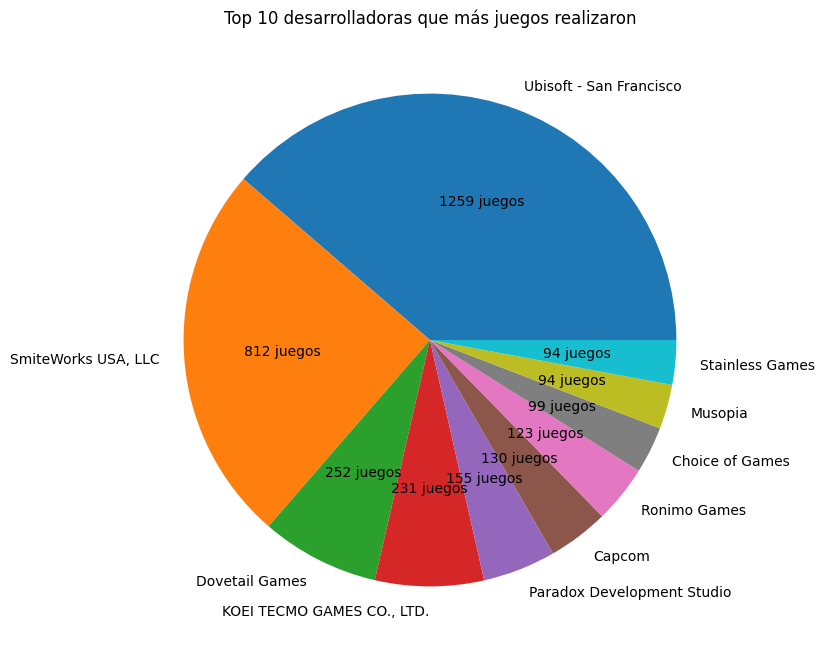

In [21]:
# Calcular la cantidad de datos por desarrollador
cantidad_juegos_por_desarrollador = games['developer'].value_counts()

# Nos quedamos con los 6 que mas juegos realizaron
top_desarrolladores = cantidad_juegos_por_desarrollador.head(10)

# Graficamos
plt.figure(figsize=(8, 8))
plt.pie(top_desarrolladores, labels=top_desarrolladores.index, autopct=lambda p: f'{int(p*sum(top_desarrolladores)/100)} juegos')
plt.title('Top 10 desarrolladoras que más juegos realizaron')
plt.show()

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30757 non-null  float64
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(3), object(10)
memory usage: 11.9+ MB


vemos la cantidad e filas y columnas

In [23]:
games.shape

(120445, 13)

Del total de columnas solo necesitariamos para este proyecto las siguientes: "id","title","genres","release_date","price","tags" y "developer". De estas columnas necesarias notamos que tienen los siguentes nulos:

In [24]:
print(games.isnull().sum())

publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89688
early_access    88310
id              88312
developer       91609
dtype: int64


Con este grafico podemos ver mejor el porsentaje de nulos 

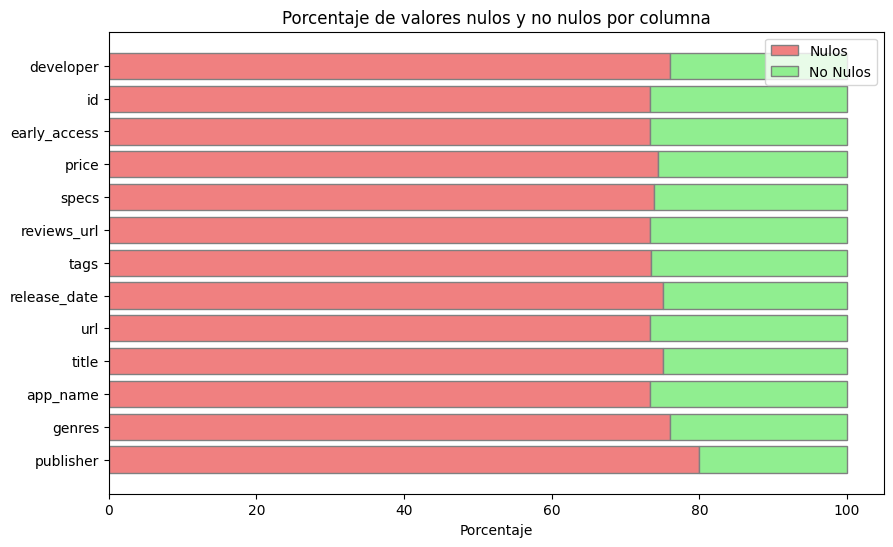

In [26]:

# Contar valores nulos y no nulos por columna
null_counts = games.isnull().sum()
non_null_counts = games.notnull().sum()

# Calcular los porcentajes
total_counts = null_counts + non_null_counts
null_percentage = (null_counts / total_counts) * 100
non_null_percentage = (non_null_counts / total_counts) * 100

# Configurar el tamaño del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Crear las barras apiladas
bars1 = ax.barh(games.columns, null_percentage, color='lightcoral', edgecolor='grey', label='Nulos')
bars2 = ax.barh(games.columns, non_null_percentage, left=null_percentage, color='lightgreen', edgecolor='grey', label='No Nulos')

# Añadir etiquetas y título
ax.set_xlabel('Porcentaje')
ax.set_title('Porcentaje de valores nulos y no nulos por columna')
ax.legend()

# Mostrar el gráfico
plt.show()

Porcedemos a eliminar nulos


In [5]:
games = games.dropna(how='all')
print(games.isnull().sum())

publisher       8052
genres          3283
app_name           2
title           2050
url                0
release_date    2067
tags             163
reviews_url        2
specs            670
price           1378
early_access       0
id                 2
developer       3299
dtype: int64


Revisamos como quedo


In [11]:
games.head()


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,combined_tags_genres
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140.0,Kotoshiro,"([Action, Casual, Indie, Simulation, Strategy]..."
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,"([Free to Play, Indie, RPG, Strategy], [Free t..."
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,"([Casual, Free to Play, Indie, Simulation, Spo..."
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400.0,彼岸领域,"([Action, Adventure, Casual], [Action, Adventu..."
88314,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,"(None, [Action, Indie, Casual, Sports])"


vemos que el id a quedamo mal debedo a las filas borradas

In [12]:
games = games.reset_index(drop=True)


In [13]:
games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,combined_tags_genres
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140.0,Kotoshiro,"([Action, Casual, Indie, Simulation, Strategy]..."
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,"([Free to Play, Indie, RPG, Strategy], [Free t..."
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,"([Casual, Free to Play, Indie, Simulation, Spo..."
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400.0,彼岸领域,"([Action, Adventure, Casual], [Action, Adventu..."
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,"(None, [Action, Indie, Casual, Sports])"


In [6]:
columns = ["id", "app_name", "genres", "release_date", "price", "developer","tags"]

for column in columns:
    print(f"El tipo de dato de la columna '{column}' es:", games[column].dtype)

El tipo de dato de la columna 'id' es: float64
El tipo de dato de la columna 'app_name' es: object
El tipo de dato de la columna 'genres' es: object
El tipo de dato de la columna 'release_date' es: object
El tipo de dato de la columna 'price' es: float64
El tipo de dato de la columna 'developer' es: object
El tipo de dato de la columna 'tags' es: object


debido a que la col genres y tags soon similares las combinamos


In [14]:
games['combined_tags_genres'] = list(zip(games['genres'], games['tags']))



# Imprimir el DataFrame resultante
games['combined_tags_genres'][1]

(['Free to Play', 'Indie', 'RPG', 'Strategy'],
 ['Free to Play',
  'Strategy',
  'Indie',
  'RPG',
  'Card Game',
  'Trading Card Game',
  'Turn-Based',
  'Fantasy',
  'Tactical',
  'Dark Fantasy',
  'Board Game',
  'PvP',
  '2D',
  'Competitive',
  'Replay Value',
  'Character Customization',
  'Female Protagonist',
  'Difficult',
  'Design & Illustration'])

Borramos las filas que quedaron nulas incluso despues de la combinacion

In [16]:
games = games.dropna(subset=['combined_tags_genres'])

al combinarla nos que dos listas o mas pasomo a combinar las lista dentro e la col

In [19]:

# Define the function to combine lists while handling None values
def combinar_listas(tupla):
    combinada = []
    if tupla is not None:
        for lista in tupla:
            if lista is not None:  # Check if the inner element is not None
                combinada.extend(lista)
    # Eliminar duplicados manteniendo el orden
    vista_unica = []
    [vista_unica.append(x) for x in combinada if x not in vista_unica]
    return vista_unica

# Apply the function to the combined_tags_genres column
games['columna_combinada'] = games['combined_tags_genres'].apply(combinar_listas)

# Verify the result

games['columna_combinada'][1]

['Free to Play',
 'Indie',
 'RPG',
 'Strategy',
 'Card Game',
 'Trading Card Game',
 'Turn-Based',
 'Fantasy',
 'Tactical',
 'Dark Fantasy',
 'Board Game',
 'PvP',
 '2D',
 'Competitive',
 'Replay Value',
 'Character Customization',
 'Female Protagonist',
 'Difficult',
 'Design & Illustration']

Reviso el df

In [20]:
games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer,combined_tags_genres,columna_combinada
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140.0,Kotoshiro,"([Action, Casual, Indie, Simulation, Strategy]...","[Action, Casual, Indie, Simulation, Strategy]"
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,"([Free to Play, Indie, RPG, Strategy], [Free t...","[Free to Play, Indie, RPG, Strategy, Card Game..."
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,"([Casual, Free to Play, Indie, Simulation, Spo...","[Casual, Free to Play, Indie, Simulation, Spor..."
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400.0,彼岸领域,"([Action, Adventure, Casual], [Action, Adventu...","[Action, Adventure, Casual]"
4,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,None,"(None, [Action, Indie, Casual, Sports])","[Action, Indie, Casual, Sports]"


Elimino columnas que no interesan


In [21]:
games = games.drop(['genres', 'tags','reviews_url','combined_tags_genres','publisher','title','url','specs','early_access','id'],axis=1)
games.rename(columns={'columna_combinada': 'genres'}, inplace=True)

In [23]:
games = games.dropna(subset=['app_name', 'release_date', 'price','genres','developer'])


In [25]:
games = games.reset_index(drop=True)

In [26]:
games.head()

,app_name,release_date,price,developer,genres
0,Lost Summoner Kitty,2018-01-04,4.99,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]"
1,Ironbound,2018-01-04,0.00,Secret Level SRL,"[Free to Play, Indie, RPG, Strategy, Card Game..."
2,Real Pool 3D - Poolians,2017-07-24,0.00,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Spor..."
3,弹炸人2222,2017-12-07,0.99,彼岸领域,"[Action, Adventure, Casual]"
4,Battle Royale Trainer,2018-01-04,3.99,Trickjump Games Ltd,"[Action, Adventure, Simulation, FPS, Shooter, ..."


In [29]:
duplicados = games[["app_name", "release_date", "price", "developer"]].duplicated().sum()
print("Cantidad de filas duplicadas:", duplicados)

Cantidad de filas duplicadas: 2


Elimino duplicados

In [ ]:
games = games[~duplicados]

In [33]:
games2=games
# Asegúrate de que 'genres' contiene listas, si no, ajusta esta línea
games2['genres'] = games['genres'].apply(lambda x: x if isinstance(x, list) else [])

# Explode la columna 'genres' para convertir listas en filas separadas
exploded_genres = games2.explode('genres')

# Ahora puedes contar y obtener los 30 géneros más comunes
top_genres = exploded_genres['genres'].value_counts().nlargest(30)

print(top_genres)


genres
Indie                    15573
Action                   11227
Adventure                 8748
Casual                    8656
Strategy                  7074
Simulation                6854
RPG                       5423
Singleplayer              4115
Multiplayer               2184
Great Soundtrack          2124
Free to Play              2028
Puzzle                    1980
2D                        1901
Atmospheric               1805
Platformer                1396
Story Rich                1384
Early Access              1382
Fantasy                   1259
Sports                    1256
Difficult                 1244
Open World                1230
Pixel Graphics            1216
Sci-fi                    1195
Female Protagonist        1131
Co-op                     1131
Massively Multiplayer     1122
Horror                    1107
Shooter                   1091
Racing                    1087
Anime                     1068
Name: count, dtype: int64


C:\Users\Mike\AppData\Local\Temp\ipykernel_16840\1818538564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_genres.index, x=top_genres.values, palette='viridis')


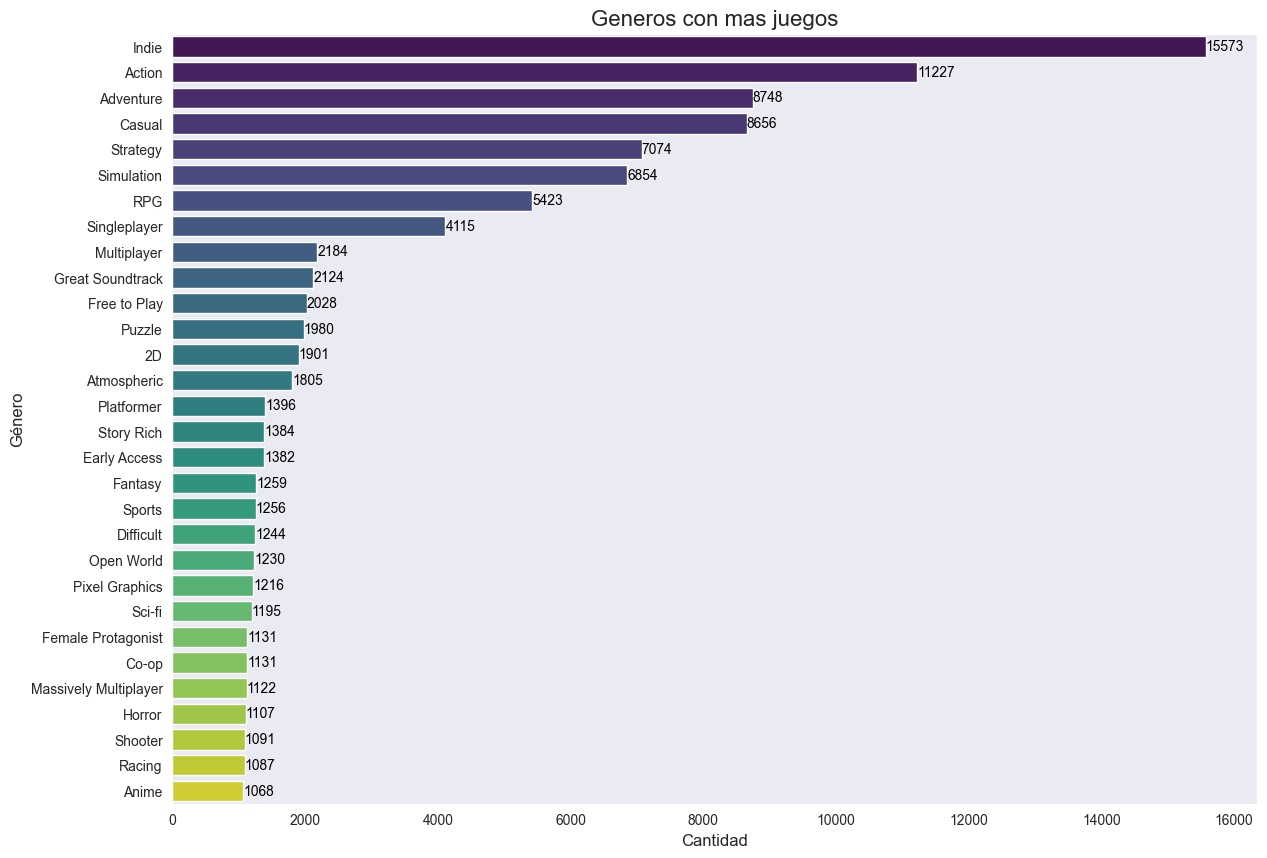

In [48]:
plt.figure(figsize=(14, 10))
sns.barplot(y=top_genres.index, x=top_genres.values, palette='viridis')

# Añadir etiquetas de valor a cada barra
for index, value in enumerate(top_genres.values):
    plt.text(value, index, f'{value}', va='center', ha='left', color='black', fontsize=10)

plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Género', fontsize=12)
plt.title('Generos con mas juegos', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

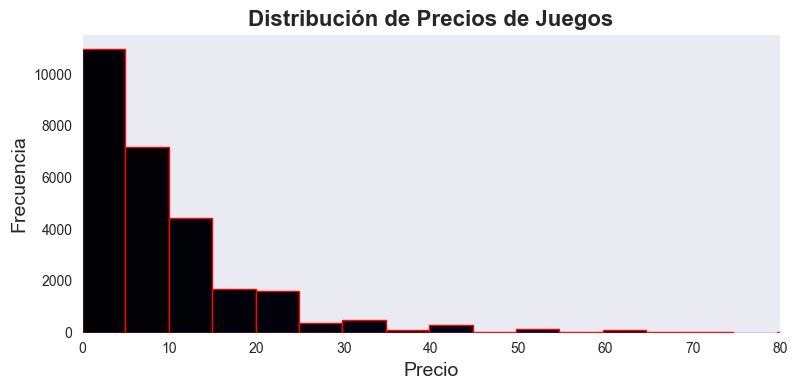

In [47]:
sns.set_style("dark")
plt.figure(figsize=(8, 4))

# Crear los datos
prices = games['price']

# Crear el gráfico con múltiples colores
n_bins = 200
colors = sns.color_palette("magma", n_bins)
n, bins, patches = plt.hist(prices, bins=n_bins, edgecolor='red')

# Asignar los colores a cada barra del histograma
for color, patch in zip(colors, patches):
    patch.set_facecolor(color)

# Agregar título y etiquetas
plt.title('Distribución de Precios de Juegos', fontsize=16, fontweight='bold')
plt.xlabel('Precio', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Ajustar los márgenes
plt.tight_layout()

# Limitar el rango del eje x (precio)
plt.xlim(0, 80)

# Mostrar el gráfico
plt.show()

--------------------------------------
## EDA: user_reviews

In [50]:
archivo = "user_reviews.json.gz"
data = []

with gzip.open(archivo, 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            json_data = ast.literal_eval(line)
            data.append(json_data)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            continue

reviews = pd.DataFrame(data)

Vemos un primer vitazo de las primeras filas y las ultimas:

In [51]:
reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [53]:
reviews.tail()

,user_id,user_url,reviews
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."
25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"[{'funny': '1 person found this review funny',..."


Notamos que la columna 'reviews' esta anidada y que tiene informacion importante siendo estas una lista de diccionarios:

In [54]:
reviews.loc[0,'reviews']

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

De esta columna anidada los valores que necesitaremos para el proyecto son items_count" e "items". Ahora vemos la información general de los datos:

In [55]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


No vemos nulos en las filas de acuerdo a la informacón general. La cantidad de filas y columnasque hay son:

In [56]:
print(f'La cantidad de filas son: {reviews.shape[0]} y de columnas son: {reviews.shape[1]}')

La cantidad de filas son: 25799 y de columnas son: 3


Notamos que en este caso solo necesitariamos las columnas: "user_id" y "reviews" para trabajar y descartar "user_url". La columna 'user_id' permite conectar con la columna "id" del dataset **steam_games**. Vemos la cantidad de filas duplicadas que hay:

In [57]:
#Filas duplicadas sin tener en cuenta la columna reviews que es una lista de diccionarios.
reviews[['user_id','user_url']].duplicated().sum()

314

------------------------
## EDA: user_items

In [59]:
items = pd.read_parquet('australian_users_items.parquet')

In [60]:
items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864384,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712560,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445856,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099488,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [61]:
items.tail()

,user_id,items_count,steam_id,user_url,items
88305,76561198323066619,22,76561198323066624,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700688,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759264,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548336,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."
88309,edward_tremethick,0,76561198331598576,http://steamcommunity.com/id/edward_tremethick,[]


Notamos la columna items como lista de diccionarios con datos imposrantes como 'item_id' para conectar con los otras datasets:

In [62]:
items.loc[0,'items']

array([{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_2weeks': 0, 'playtime_forever': 6},
       {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_2weeks': 0, 'playtime_forever': 7},
       {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '60', 'item_name': 'Ricochet', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '70', 'item_name': 'Half-Life', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '300', 'item_name': 'Day of Defeat: Source', 'playtime_2weeks': 0, 'playtime_forever': 4733},
       {'item_id': '240', 'item_name': 'Counter-Strik

In [63]:
print(f"La cantidad de filas son: {items.shape[0]} y columnas son: {items.shape[1]}")

La cantidad de filas son: 88310 y columnas son: 5


In [65]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  int64 
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


Notamos el maximo muy elevado que puede ser un outliers, vemos su distribución graficamente:

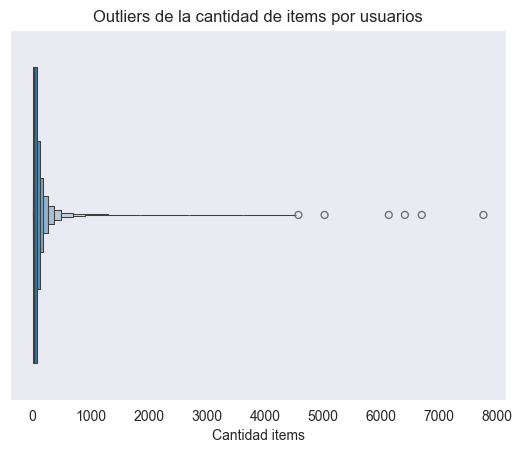

In [66]:
sns.boxenplot(x=items['items_count'])
plt.xlabel('Cantidad items')
plt.title('Outliers de la cantidad de items por usuarios')
plt.show()

La mayoria de los valores se encuentran por debajo de los 1000 items. Usamos la regla de los 3 sigmas para entontrar la cantidad de valores outliers muy extremos:

In [67]:
# Regla de los 3 sigmas:

cantidad_items_promedio = items['items_count'].mean()
deviacion_estandar_cantidad_items = items['items_count'].std()
limite_superior = cantidad_items_promedio + 3 * deviacion_estandar_cantidad_items
limite_inferior = cantidad_items_promedio - 3 * deviacion_estandar_cantidad_items

cantidad_outliers = len(items['items_count'][(items['items_count'] > limite_superior) | (items['items_count'] < limite_inferior)])

print(f"Los conciderados outliers extremos segun la regla de las 3 sigma son: {cantidad_outliers}")

Los conciderados outliers extremos segun la regla de las 3 sigma son: 933


Estos valores outliers extremos sacaremos para tener un dataset field a la realidad. Ahora vemos los valores duplicados sin tener en cuenta la columna anidada 'items':

In [68]:
duplicados_user_items = items[['user_id', 'items_count', 'steam_id', 'user_url']].duplicated().sum()
print(f"La cantidad de duplicados sin desanidar son: {duplicados_user_items}")

La cantidad de duplicados sin desanidar son: 684
